In [ ]:
"""
3/19/2021

Goal:
Visualization of model (Random forest) results

1. Feature importance
2. Density by label


**This notebook kept all types of plots tried for future reference**

"""

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, recall_score, precision_recall_curve,f1_score, fbeta_score, log_loss

pd.set_option('display.max_columns', None)

## Load data and create df
* .csv files already include both blurriness and face info (with more details)
* larger dataset(1832 rows)

In [2]:
bad = pd.read_csv('./OpenCV_blur/TEST_face_features_bad_bare.csv')
good = pd.read_csv('./OpenCV_blur/TEST_face_features_good_bare.csv')

In [3]:
test = pd.concat([bad,good],axis=0).reset_index(drop=True)

In [4]:
import ast
# Convert to actual list and count number of eyes/ears/nose detected
test['eyes'] = test['eyes'].apply(lambda x: ast.literal_eval(x))
test['num_eye'] = test['eyes'].apply(lambda x: len(x))
test['ears'] = test['ears'].apply(lambda x: ast.literal_eval(x))
test['num_ear'] = test['ears'].apply(lambda x: len(x))
test['nose'] = test['nose'].apply(lambda x: ast.literal_eval(x))
test['num_nose'] = test['nose'].apply(lambda x: len(x))

# eye position
test['eye_x1'] = test['eyes'].apply(lambda x: x[0][0] if (len(x)>0) else 0)
test['eye_y1'] = test['eyes'].apply(lambda x: x[0][1] if (len(x)>0) else 0)
test['eye_x2'] = test['eyes'].apply(lambda x: x[1][0] if (len(x)>1) else 0)
test['eye_y2'] = test['eyes'].apply(lambda x: x[1][1] if (len(x)>1) else 0)
# eye width
test['eye_w1'] = test['eyes'].apply(lambda x: x[0][2] if (len(x)>0) else 0)
test['eye_w2'] = test['eyes'].apply(lambda x: x[1][2] if (len(x)>1) else 0)
test['eye_w'] = test['eyes'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 0)
# eye height
test['eye_h1'] = test['eyes'].apply(lambda x: x[0][3] if (len(x)>0) else 0)
test['eye_h2'] = test['eyes'].apply(lambda x: x[1][3] if (len(x)>1) else 0)
test['eye_h'] = test['eyes'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 0)
# eye size and ratio to face size
test['eye_size'] = test['eye_w']*test['eye_h']
test['eye_ratio'] = test['eye_size'] / test['face_size']

# nose position
test['nose_x'] = test['nose'].apply(lambda x: x[0][0] if (len(x)>0) else 0)
test['nose_y'] = test['nose'].apply(lambda x: x[0][1] if (len(x)>0) else 0)

# ear width
test['ear_w1'] = test['ears'].apply(lambda x: x[0][2] if (len(x)>0) else 0)
test['ear_w2'] = test['ears'].apply(lambda x: x[1][2] if (len(x)>1) else 0)
test['ear_w'] = test['ears'].apply(lambda x: sum([x[i][2] for i in range(len(x))])/len(x) if len(x)!=0 else 0)
# ear height
test['ear_h1'] = test['ears'].apply(lambda x: x[0][3] if (len(x)>0) else 0)
test['ear_h2'] = test['ears'].apply(lambda x: x[1][3] if (len(x)>1) else 0)
test['ear_h'] = test['ears'].apply(lambda x: sum([x[i][3] for i in range(len(x))])/len(x) if len(x)!=0 else 0)

In [5]:
# add video column
test['video'] = test['filename'].apply(lambda x: x.split('.M')[0])
test['video'] = test['filename'].apply(lambda x: x.lower().split('.m')[0])

# Examine cat face detection
test['avg_face'] = test.groupby(['video'])['face_size'].transform(np.mean)
test['avg_to_ctr'] = test.groupby(['video'])['to_ctr'].transform(np.mean)
# Correct face_size
correct_face = test.apply(lambda x: x.face_size if x.face_size>10000 else x.avg_face, axis=1)
test['face_size'] = correct_face
# Correct to_ctr
correct_to_crt = test.apply(lambda x: x.to_ctr if x.face_size>10000 else x.avg_to_ctr, axis=1)

In [6]:
# Add 'label' as the last column
label_list = ['bad']*bad.shape[0] + ['good']*good.shape[0]
test['label'] = label_list
# test.iloc[:,:]

In [7]:
frame_data = test.copy()

### A. Conventional train test split

In [8]:
df = frame_data.copy()
# Train test split
X = df.iloc[:,:-1]

mapping = {'bad':0, 'good':1}
y = df['label'].map(mapping)

X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

In [77]:
df = frame_data.copy()
# Train test split
X = df.iloc[:,:-1]

mapping = {'bad':0, 'good':1}
y = df['label'].map(mapping)

X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

### B. Proper train test split

In [9]:
# Make sure all the frames in test set are from videos not seen in training set
# Test set size: ~367 frames
df = frame_data.copy()
# df.head(370)

In [10]:
video_file = 'IMG_0185'
temp_df = df[df.video == video_file][['face_size','avg_face','video']]
# temp_df.face_size.hist(bins=50);

In [11]:
# ax = sns.boxplot(x="video", y="face_size", data=temp_df)
# ax = sns.swarmplot(x="video", y="face_size", data=temp_df, color=".25")

In [12]:
# temp_df.sort_values('face_size')

In [13]:
df.video.unique()

array(['img_0185', 'img_0186', 'img_0187', 'img_0242', 'img_0243',
       'img_0244', 'img_0245', 'img_0246', 'img_0250', 'img_0251',
       'img_0253', 'img_0257', 'img_0258', 'img_0259', 'img_0261',
       'img_0262', 'img_0263', 'img_0267', 'img_0268', 'img_0271',
       'img_3554', 'img_3572', 'img_4245', 'img_5179.trim', 'img_8976',
       'img_9181', 'img_9953', 'junskitchen_1', 'img_3555',
       'joined_video_54ba02eb70fc40e4a4d6dd164fd11e70'], dtype=object)

In [14]:
df.video.nunique()

30

In [15]:
# Use frames from 12 videos as test set
test_video = df.groupby('video').count().iloc[10:22,:].index.tolist()
len(test_video)

12

In [16]:
# Separate features and target
X = df.iloc[:,:-4]

mapping = {'bad':0, 'good':1}
y = df['label'].map(mapping)


# Manual tran test split
X_train_df = df[~df.video.isin(test_video)].iloc[:,:-4]
X_test_df = df[df.video.isin(test_video)].iloc[:,:-4]

y_train = df[~df.video.isin(test_video)]['label'].map(mapping)
y_test = df[df.video.isin(test_video)]['label'].map(mapping)

In [17]:
len(X_train_df),len(X_test_df)

(1704, 128)

### Reset train_df and test_df index

In [78]:
# Reset index
X_train_df.reset_index(inplace=True,drop=True)
X_test_df.reset_index(inplace=True,drop=True)
y_train.reset_index(inplace=True,drop=True)
y_test.reset_index(inplace=True,drop=True)

In [79]:
# X_test_df

In [80]:
X_test_df.columns

Index(['filename', 'lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny',
       'lp_all_canny', 'lp_ratio_canny', 'blur', 'to_ctr', 'cat_x', 'cat_y',
       'face_size', 'size_ratio', 'eyes', 'ears', 'nose', 'num_eye', 'num_ear',
       'num_nose', 'eye_x1', 'eye_y1', 'eye_x2', 'eye_y2', 'eye_w1', 'eye_w2',
       'eye_w', 'eye_h1', 'eye_h2', 'eye_h', 'eye_size', 'eye_ratio', 'nose_x',
       'nose_y', 'ear_w1', 'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h',
       'video', 'avg_face', 'avg_to_ctr'],
      dtype='object')

In [81]:
# X_test_df.info()

In [82]:
# y_test

## Scale continuous variables

In [83]:
headers = ['filename','lp_cat','lp_all','lp_ratio','lp_cat_canny','lp_all_canny','lp_ratio_canny','blur',\
               'to_ctr','cat_x','cat_y','face_size','size_ratio',\
               'eyes','ears','nose']

In [84]:
# Continuous variables
features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny',\
#             'cat_x', 'cat_y',
            'face_size', 'size_ratio', 'to_ctr',\
            'num_eye','num_ear', 'num_nose', 
            'eye_w1', 'eye_w2', 'eye_w', 'eye_h1', 'eye_h2', 'eye_h',
            'eye_size', 'eye_ratio',
            'ear_w1', 'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h',
#             'eye_x1', 'eye_y1', 'eye_x2', 'eye_y2',
#             'nose_x'
           ]
X_train_con = X_train_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_train_con_scaled = scaler.fit_transform(X_train_df[features])
cont_columns = X_train_con.columns
X_train_con_df = pd.DataFrame(X_train_con_scaled, columns=cont_columns, index=X_train_con.index)
# X_train_con_df

In [85]:
# Try without 'blur'
X_train = X_train_con_df

In [86]:
# # Combine Con and Cat
# X_train = pd.concat([X_train_con_df,X_train_df[['blur']]], axis='columns')
# X_train

In [87]:
# Repeat for test set
# Continuous variables
# features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny', 'size_ratio', 'to_ctr']
X_test_con = X_test_df[features]

# Since we're using more than one feature, let's scale our features
scaler = StandardScaler()
X_test_con_scaled = scaler.fit_transform(X_test_df[features])
cont_columns = X_test_con.columns
X_test_con_df = pd.DataFrame(X_test_con_scaled, columns=cont_columns, index=X_test_con.index)

# Combine Con and Cat
X_test = pd.concat([X_test_con_df,X_test_df[['blur']]], axis='columns')
# X_test

In [88]:
# Try without 'blur'
X_test = X_test_con_df

## 1. Logistic regression

### A. Basic

In [89]:
from sklearn.linear_model import LogisticRegression

lm = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

lm.fit(X_train, y_train)
print('intercept: ', round(lm.intercept_[0], 4))
lr_features = pd.DataFrame(list(zip(X_train.columns,np.transpose(lm.coef_[0]))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)
lr_features.head()

intercept:  0.1672


Feature      Coef
20        ear_w1  2.193073
7     size_ratio  2.180997
0         lp_cat  2.098791
16        eye_h2  1.926551
3   lp_cat_canny  1.753772

In [90]:
y_predict = lm.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

Predict-Bad (0)  Predict-Good (1)
Bad (0)               113                41
Good (1)               19               194

In [91]:
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion/np.sum(fraud_confusion), cmap=plt.cm.Blues,
           annot=True, square=True, fmt='.2%',
           xticklabels=['Bad', 'Good'],
           yticklabels=['Bad', 'Good']);
    plt.xlabel('prediction')
    plt.ylabel('actual')

In [92]:
# from ipywidgets import interactive, FloatSlider
# interactive(lambda threshold: make_confusion_matrix(lm, threshold), threshold=(0.0,1.0,0.02))

In [93]:
# print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
# print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

In [94]:
# Define plot_roc function
def plot_roc(model_name,model):
    y_scores = model.predict_proba(X_test)
    fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)

    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC of '+ model_name)
    plt.show()

In [95]:
# # Logistic regression ROC curve
# plot_roc('Logistic Regression', lm)

### B. Hyperparameter Tuning

In [96]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

# define models and parameters
model = LogisticRegression()
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)

In [97]:
# note that train and validation sets are not split properly!

In [98]:
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.806113 using {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}


In [99]:
# Use best model on test set
lm_best = grid_result.estimator
lm_best.fit(X_train,y_train)
y_predict = lm_best.predict(X_test)
pd.DataFrame(confusion_matrix(y_test, y_predict),\
             columns=['Predict-Bad (0)','Predict-Good (1)'],\
            index=['Bad (0)','Good (1)'])

Predict-Bad (0)  Predict-Good (1)
Bad (0)               113                41
Good (1)               19               194

In [100]:
# print('intercept: ', round(lm.intercept_[0], 4))
# pd.DataFrame(list(zip(X_train.columns,np.transpose(lm_best.coef_[0]))),columns=['Feature','Coef'])\
# .sort_values('Coef',ascending=False).head(5)

In [101]:
# print('Accuracy score:',accuracy_score(y_test,y_predict),'\n')
# print('Classification report (Logistic regression):\n\n',classification_report(y_test,y_predict))

In [102]:
# # Logistic regression ROC curve
# plot_roc('Best Logistic Regression', lm_best)

In [103]:
# Only small improvement compared to the basic model!

## 2. Random Forests

### A. Basic

In [104]:
def quick_test(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

def quick_test_afew_times(model, X_train, y_train, X_test, y_test, n=10):
    return np.mean([quick_test(model, X_train, y_train, X_test, y_test) for j in range(n)])

In [105]:
from sklearn.ensemble import RandomForestClassifier
# Random Forests
randomforest = RandomForestClassifier(n_estimators=200)
quick_test_afew_times(randomforest, X_train, y_train, X_test, y_test)

0.9

In [106]:
# Save the model! (pickle)
import pickle
randomforest.fit(X_train, y_train)
pickle.dump(randomforest, open('./dump/randomforest.pkl','wb'))

In [107]:
pred = randomforest.predict(X_test)
# print('Accuracy score:',accuracy_score(y_test,pred),'\n')
# print('Classification report (Random Forests):\n\n',classification_report(y_test,pred))

In [108]:
# # Random Forest ROC curve
# plot_roc('Random Forest', randomforest)

In [109]:
# interactive(lambda threshold: make_confusion_matrix(randomforest, threshold), threshold=(0.0,1.0,0.02))

In [110]:
# # def plot_roc(model_name,model):
# model_name = 'Random forest'
# model = randomforest
# y_scores = model.predict_proba(X_test)
# fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1],drop_intermediate=False)
# roc_auc = auc(fpr, tpr)
# plt.plot(fpr, tpr, 'b', label = 'AUC = %0.3f' % roc_auc)

# plt.legend(loc = 'lower right')
# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0, 1])
# plt.ylim([0, 1])
# plt.ylabel('True Positive Rate')
# plt.xlabel('False Positive Rate')
# plt.title('ROC of '+ model_name)
# plt.show()

In [111]:
# fpr_tpr = pd.DataFrame([fpr,tpr]).transpose().reset_index(drop=True)
# fpr_tpr.columns = ['fpr','tpr']
# # fpr_tpr

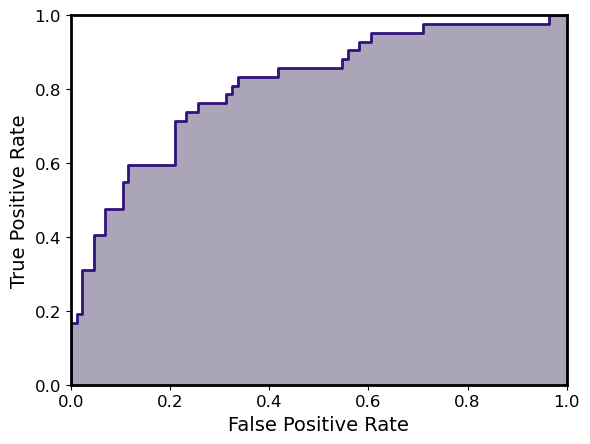

In [112]:
fig, ax = plt.subplots()

# # pd.DataFrame(tpr,fpr).plot.area(alpha=0.4)
# y_scores = lm.predict_proba(X_test)
# fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
# roc_auc = auc(fpr, tpr)

plt.stackplot(fpr, tpr,alpha=0.5,color='#584D74')
# plt.plot(fpr, tpr,'o',color='cadetblue',alpha=0.6,fillstyle='none',ms=3)
plt.plot(fpr, tpr, color='#32137C', linewidth=2, label = 'Logistic Regression = %0.3f' % roc_auc)

# plt.plot([0, 1], [0, 1],'k--',label = 'Random guess = 0.5')

# plt.legend(loc = 'lower right',bbox_to_anchor=(1.6, 0))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
# plt.title('Receiver Operating Characteristic Curve',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

# fig.savefig('./plot/ROC_rf.pdf', bbox_inches='tight', transparent=True)

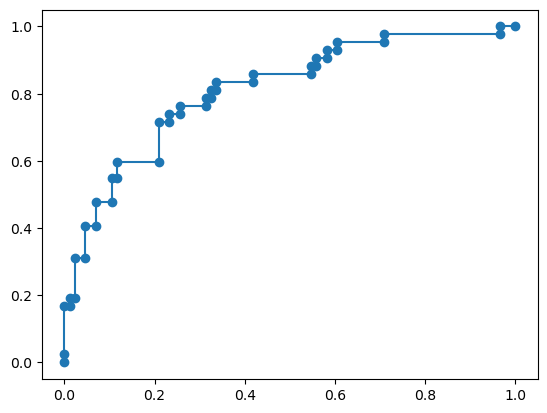

In [113]:
x = fpr
y = tpr
plt.plot(x,y,'o-');

In [114]:
mean_fpr = np.linspace(0,1,100)
interp_tpr = np.interp(mean_fpr, fpr, tpr)

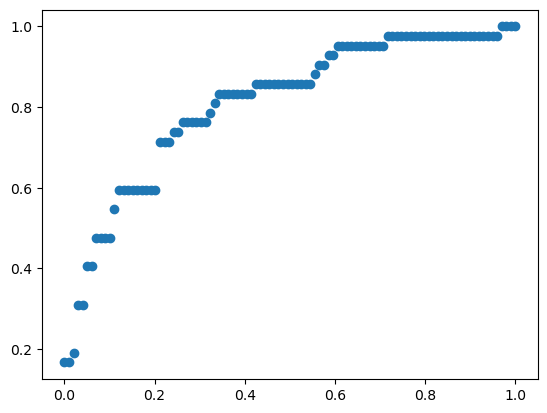

In [115]:
x = mean_fpr
y = interp_tpr
plt.plot(x,y,'o');

In [153]:
def my_roc_curve(y, prob):
    tpr_list = []
    fpr_list = []
    threshold = np.linspace(1.1, 0, 2000)
    for t in threshold:
        y_pred = np.zeros(y.shape[0])
        y_pred[prob >= t] = 1
        TN = y_pred[(y_pred == y) & (y == 0)].shape[0]
        TP = y_pred[(y_pred == y) & (y == 1)].shape[0]
        FP = y_pred[(y_pred != y) & (y == 0)].shape[0]
        FN = y_pred[(y_pred != y) & (y == 1)].shape[0]
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        tpr_list.append(TPR)
        fpr_list.append(FPR)
    return fpr_list, tpr_list, threshold

def my_predict_proba(x):
    return(np.random.uniform(0, 1, x.shape[0]))

# prob = my_predict_proba(x)
fpr, tpr, threshold = my_roc_curve(y_test, y_scores[:, 1])

# plt.plot(fpr, tpr, 'b')
# plt.plot([0,1],[0,1], 'r--')
# plt.xlabel("False Positive Rate", fontsize=12)
# plt.ylabel("True Positive Rate", fontsize=12)

# plt.show()

In [ ]:
y_scores = model.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

In [ ]:
fpt_tpr = pd.DataFrame(fpr,tpr).reset_index()
fpt_tpr.columns=['fpr','tpr']
# fpt_tpr

In [ ]:
alt.Chart(fpt_tpr).mark_line().encode(
    alt.X('tpr:Q'),
    alt.Y('fpr:Q'),
#     color='sex:N'
#     , axis=alt.Axis(format='%')
)

In [ ]:
fig, ax = plt.subplots()

# pd.DataFrame(tpr,fpr).plot.area(alpha=0.4)
y_scores = lm.predict_proba(X_test)
fpr, tpr, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.stackplot(fpr, tpr,alpha=0.3)
# plt.plot(fpr, tpr, 'cadetblue', linewidth=3.5, label = 'Logistic Regression = %0.3f' % roc_auc)
plt.plot(fpr, tpr,'o')
# plt.plot([0, 1], [0, 1],'k--',label = 'Random guess = 0.5')

# plt.legend(loc = 'lower right',bbox_to_anchor=(1.6, 0))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate',fontsize=14)
plt.xlabel('False Positive Rate',fontsize=14)
plt.title('Model Performance (ROC)',fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);

# fig.savefig('../plot/ROC_lr_2.pdf', bbox_inches='tight', transparent=True)

### Ranfom forest feature importatnce

In [ ]:
rf_features = pd.DataFrame(list(zip(X_train.columns,np.transpose(randomforest.feature_importances_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)
rf_features.head(6)

In [ ]:
# Example of polar plot
plt.style.use('default')
employee = ["Sam", "Rony", "Albert", "Chris", "Jahrum"]
actual = [45, 53, 55, 61, 57, 45]
expected = [50, 55, 60, 65, 55, 50]
 
# Initialise the spider plot by setting figure size and polar projection
plt.figure(figsize=(4, 4))
plt.subplot(polar=True)
 
theta = np.linspace(0, 2 * np.pi, len(actual))
 
# Arrange the grid into number of sales equal parts in degrees
lines, labels = plt.thetagrids(range(0, 360, int(360/len(employee))), (employee))
 
# Plot actual sales graph
plt.plot(theta, actual)
plt.fill(theta, actual, 'b', alpha=0.1)
 
# Plot expected sales graph
plt.plot(theta, expected)
 
# Add legend and title for the plot
plt.legend(labels=('Actual', 'Expected'), loc=1)
plt.title("Actual vs Expected sales by Employee")
 
# Dsiplay the plot on the screen
plt.show()

In [ ]:
rf_features.head(10)
# .sort_values('Feature')

In [ ]:
# rf_features['Feature'].head(8).tolist()
# actual = rf_features['Coef'].head(8).tolist()
# actual += [actual[0]]
# actual

In [ ]:
employee = ["Sam", "Rony", "Albert", "Chris", "Jahrum"]

actual = [45, 53, 55, 61, 57, 45]
expected = [50, 55, 60, 65, 55, 50]
employee = rf_features['Feature'].head(8).tolist()
actual = rf_features.head(8)['Coef'].tolist()
actual += [actual[0]]
 
# Initialise the spider plot by setting figure size and polar projection
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(polar=True)
ax.grid(lw=.3)
 
theta = np.linspace(0, 2 * np.pi, len(actual))
 
# Arrange the grid into number of sales equal parts in degrees
lines, labels = plt.thetagrids(range(0, 360, int(360/len(employee))), (employee))
 
# Plot actual sales graph
plt.plot(theta, actual,lw=1)
plt.fill(theta, actual, 'b', alpha=0.1)
 
# Plot expected sales graph
# plt.plot(theta, expected)
 
# Add legend and title for the plot
# plt.legend(labels=('Actual', 'Expected'), loc=1)
plt.title("Important Features")
# ax.set_xticklabels([])
# ax.set_yticklabels([])
 
# Dsiplay the plot on the screen
plt.show()

In [ ]:
employee = rf_features['Feature'].head(8).tolist()
actual = rf_features.head(8)['Coef'].tolist()
actual += [actual[0]]
 
# Initialise the spider plot by setting figure size and polar projection
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(polar=True)
ax.grid(lw=.5,color='white')
 
theta = np.linspace(0, 2 * np.pi, len(actual))
 
# Arrange the grid into number of sales equal parts in degrees
lines, labels = plt.thetagrids(range(0, 360, int(360/len(employee))), (employee))
 
# Plot actual sales graph
plt.plot(theta, actual,lw=2, color = '#497B4B')
plt.fill(theta, actual, '#88BE43', alpha=0.5)
 
# Plot expected sales graph
# plt.plot(theta, expected)
 
# Add legend and title for the plot
# plt.legend(labels=('Actual', 'Expected'), loc=1)
# plt.title("Important Features")
ax.set_xticklabels([])
ax.set_yticklabels([])
 
# Dsiplay the plot on the screen
plt.show()

fig.savefig('./plot/feature_polar.pdf', bbox_inches='tight', transparent=True)

### Random forest visualization

In [117]:
from sklearn.datasets import load_iris
from sklearn import tree


# For one tree
plt.style.use('dark_background')
plt.style.use('default')
# sns.set_style('whitegrid')
fn=X_test.columns
cn=['Bad','Good']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (10,10), dpi=1200)
tree.plot_tree(randomforest.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True,
               fontsize = 3);
# fig.savefig('rf_individualtree.png')

In [118]:
# # For 5 trees
# # This may not the best way to view each estimator as it is small
# plt.style.use('dark_background')
# fn=X_test.columns
# cn=['Bad','Good']
# fig, axes = plt.subplots(nrows = 1,ncols = 5,figsize = (10,2), dpi=900)
# for index in range(0, 5):
#     tree.plot_tree(rf.estimators_[index],
#                    feature_names = fn, 
#                    class_names=cn,
#                    filled = True,
#                    ax = axes[index]);

#     axes[index].set_title('Estimator: ' + str(index), fontsize = 11)
# # fig.savefig('rf_5trees.png')

## Examine model results

In [119]:
# Specify the model to check
# model = lm_best
# model = randomforest
# model = xgb
# model = ada

In [120]:
# For train test split
test_df = pd.DataFrame(y_test)
test_df['prob'] = model.predict_proba(X_test)[:, 1]
# test_df

In [121]:
# test_df

### Compare prediction and label
Probability distribution of good and bad frames.

In [122]:
# test_df

In [123]:
# test_df.video.nunique()

In [124]:
# Original label of test set
test_df = pd.DataFrame(y_test)

# Specify the model to check
model = lm_best
test_df['prob'] = model.predict_proba(X_test)[:, 1]
test_result = test_df[['label','prob']]
# test_result.columns = ['label','Probability']
# test_result

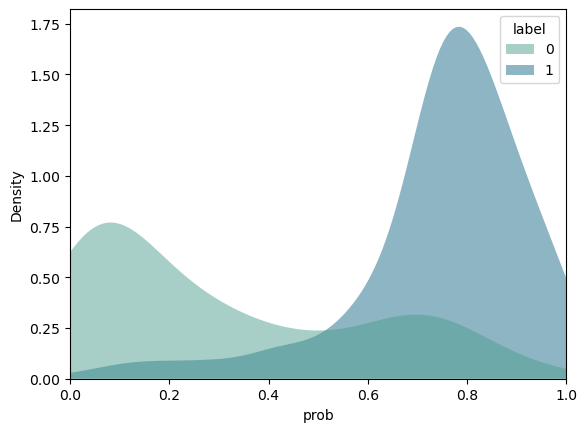

In [125]:
plt.style.use('default')
# Logistic regression
fig, ax = plt.subplots()
ax = sns.kdeplot(data=test_result, x="prob", hue="label",
            fill=True, common_norm=True, palette="crest",
            alpha=.5, linewidth=0);
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim([0,1]);

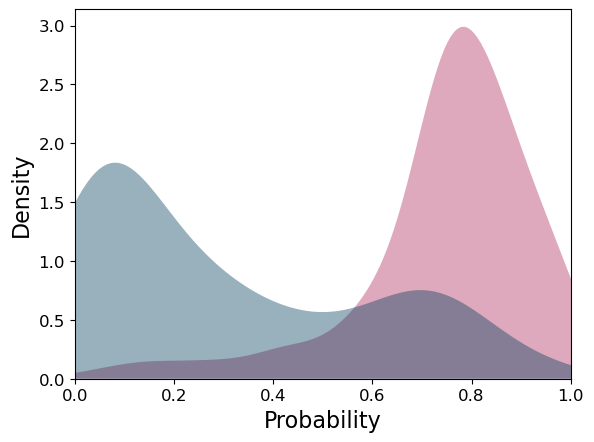

In [126]:
# Set color palette
colors = ["#ff9e9b","#b4c8e0"]
colors = ["#013B5B","#AE285C"]
sns.set_palette(sns.color_palette(colors))

# Logistic regression
fig, ax = plt.subplots()
ax = sns.kdeplot(data=test_result, x="prob", hue="label",
            fill=True, common_norm=False,
#             palette="crest",
            alpha=.4, linewidth=0,
            legend=False);
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("Probability",fontsize=16)
ax.set_ylabel("Density",fontsize=16)
ax.tick_params(labelsize=12)

plt.xlim([0,1]);
fig.savefig('./plot/kde_rf.pdf', bbox_inches='tight', transparent=True)

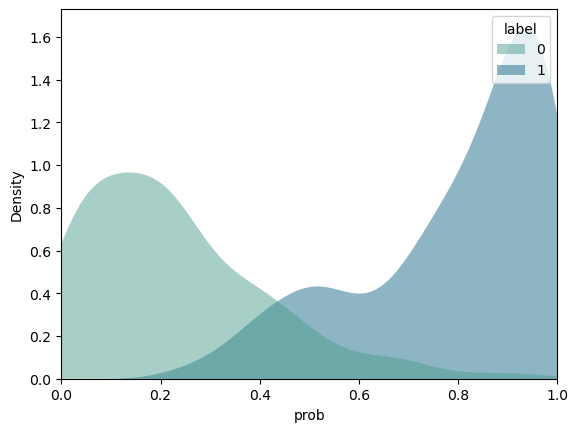

In [127]:
# Random forest
# Specify the model to check
model = randomforest
test_df['prob'] = model.predict_proba(X_test)[:, 1]
test_result = test_df[['label','prob']]

fig, ax = plt.subplots()
ax = sns.kdeplot(data=test_result, x="prob", hue="label",
            fill=True, common_norm=True,
            palette="crest",
            alpha=.5, linewidth=0);
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlim([0,1]);

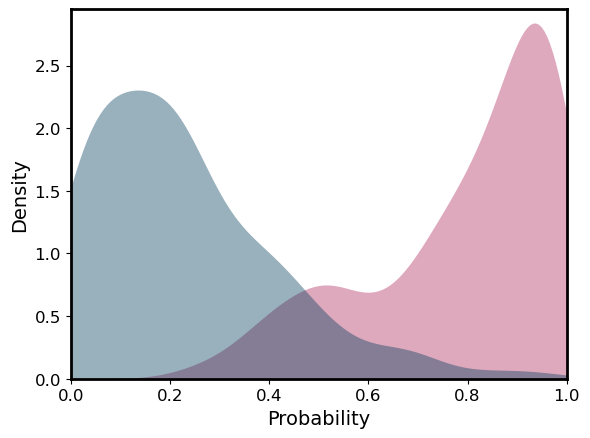

In [128]:
# Set color palette
colors = ["#ff9e9b","#b4c8e0"]
colors = ["#013B5B","#AE285C"]
sns.set_palette(sns.color_palette(colors))

# Random forest
fig, ax = plt.subplots()
ax = sns.kdeplot(data=test_result, x="prob", hue="label",
            fill=True, common_norm=False,
#             palette="crest",
            alpha=.4, linewidth=0,
            legend=False);
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("Probability",fontsize=16)
ax.set_ylabel("Density",fontsize=16)
ax.tick_params(labelsize=12)

plt.xlabel('Probability',fontsize=14)
plt.ylabel('Density',fontsize=14)
# plt.title('Receiver Operating Characteristic Curve',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.xlim([0,1])
plt.ylim([0,2.95]);
fig.savefig('./plot/kde_rf.pdf', bbox_inches='tight', transparent=True)

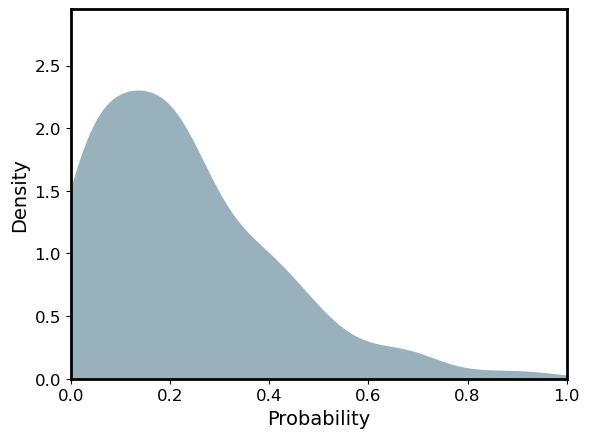

In [129]:
# Separate to save individual plot
# Set color palette
colors = ["#ff9e9b","#b4c8e0"]
colors = ["#013B5B","#AE285C"]
sns.set_palette(sns.color_palette(colors))

# Random forest
fig, ax = plt.subplots()
ax = sns.kdeplot(data=test_result[test_result.label==0], x="prob", hue="label",
            fill=True, common_norm=False,
#             palette="crest",
            alpha=.4, linewidth=0,
            legend=False);
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("Probability",fontsize=16)
ax.set_ylabel("Density",fontsize=16)
ax.tick_params(labelsize=12)

plt.xlabel('Probability',fontsize=14)
plt.ylabel('Density',fontsize=14)
# plt.title('Receiver Operating Characteristic Curve',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.xlim([0,1])
plt.ylim([0,2.95]);
fig.savefig('./plot/kde_rf_bad.pdf', bbox_inches='tight', transparent=True)

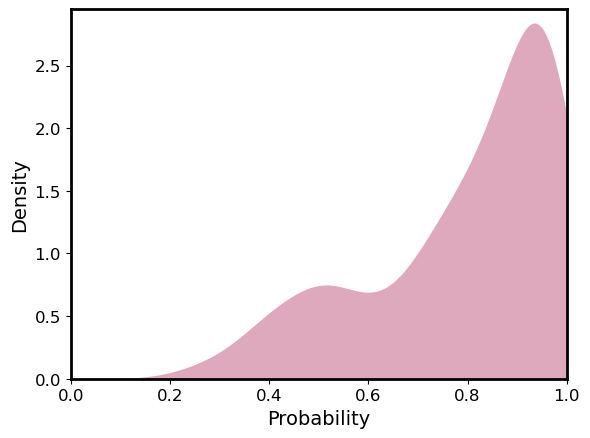

In [130]:
# Separate to save individual plot
# Set color palette
colors = ["#ff9e9b","#b4c8e0"]
colors = ["#AE285C"]
sns.set_palette(sns.color_palette(colors))

# Random forest
fig, ax = plt.subplots()
ax = sns.kdeplot(data=test_result[test_result.label==1], x="prob", hue="label",
            fill=True, common_norm=False,
#             palette="crest",
            alpha=.4, linewidth=0,
            legend=False);
# ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xlabel("Probability",fontsize=16)
ax.set_ylabel("Density",fontsize=16)
ax.tick_params(labelsize=12)

plt.xlabel('Probability',fontsize=14)
plt.ylabel('Density',fontsize=14)
# plt.title('Receiver Operating Characteristic Curve',fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.xlim([0,1])
plt.ylim([0,2.95]);
fig.savefig('./plot/kde_rf_good.pdf', bbox_inches='tight', transparent=True)

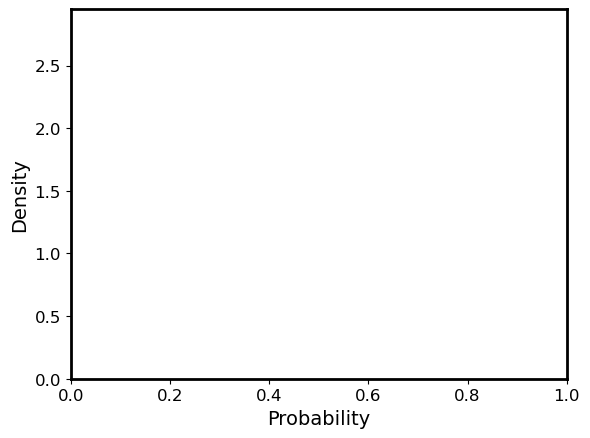

In [131]:
# Empty frame and axes ticks/ticklabels
fig, ax = plt.subplots()
ax.set_xlabel("Probability",fontsize=16)
ax.set_ylabel("Density",fontsize=16)
ax.tick_params(labelsize=12)

plt.xlabel('Probability',fontsize=14)
plt.ylabel('Density',fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12);
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)

plt.xlim([0,1])
plt.ylim([0,2.95]);
fig.savefig('./plot/kde_rf_frame.pdf', bbox_inches='tight', transparent=True)

In [132]:
def move_legend(ax, new_loc, **kws):
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

### Feature importance bar plot

In [133]:
import altair as alt
from vega_datasets import data

source = data.barley()

alt.Chart(source).mark_bar().encode(
    x='sum(yield)',
    y='variety',
    color='site',
)

alt.Chart(...)

In [134]:
model_name = 'Logistic Regression'
feature_df = lr_features
def feature_dataframe(model_name,feature_df):
    # feature_df = feature_df.head()
    feature_df_t = np.transpose(feature_df)
    new_header = feature_df_t.iloc[0]
    feature_df_t = feature_df_t[1:]
    feature_df_t.columns = new_header
    feature_df_t['model'] = model_name
    return feature_df_t

In [135]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=100, random_state=0)
ada.fit(X_train,y_train)
pred = ada.predict(X_test)
ada_features = pd.DataFrame(list(zip(X_train.columns,np.transpose(ada.feature_importances_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)


from sklearn.ensemble import GradientBoostingClassifier
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                max_depth=1, random_state=0).fit(X_train, y_train)
pred = gb.predict(X_test)
gb_features = pd.DataFrame(list(zip(X_train.columns,np.transpose(gb.feature_importances_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

import xgboost as xgb
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train,y_train)
pred = xgb.predict(X_test)
xgb_features = pd.DataFrame(list(zip(X_train.columns,np.transpose(xgb.feature_importances_))),columns=['Feature','Coef'])\
.sort_values('Coef',ascending=False)

In [136]:
lr_feature_df = feature_dataframe(model_name,feature_df)
rf_feature_df = feature_dataframe('Random Forest',rf_features)
ada_feature_df = feature_dataframe('AdaBoost',ada_features)
gb_feature_df = feature_dataframe('Gradient Boost',gb_features)
xgb_feature_df = feature_dataframe('XGBoost',xgb_features)

features_all = pd.concat([lr_feature_df,rf_feature_df,ada_feature_df,gb_feature_df,xgb_feature_df],axis=0).\
                reset_index(drop=True)
features_all

ear_w1 size_ratio     lp_cat     eye_h2 lp_cat_canny      eye_w  \
0     2.19307      2.181    2.09879    1.92655      1.75377    1.10201   
1   0.0226348  0.0420294  0.0413619  0.0747275    0.0873228  0.0281661   
2        0.05       0.07       0.04       0.03         0.07       0.01   
3  0.00382237   0.103634          0   0.275031     0.159454          0   
4   0.0253697  0.0310789  0.0212989   0.228509    0.0735261  0.0137355   

      eye_w1     ear_w2    num_eye      eye_h1    num_nose  eye_ratio  \
0   0.846626   0.575402   0.524878    0.331515   0.0899979  0.0853135   
1   0.025357  0.0116658  0.0254775    0.049568  0.00440383  0.0479073   
2       0.03       0.03          0        0.04        0.01       0.02   
3          0   0.242689          0  0.00912056           0  0.0100872   
4  0.0269503  0.0195329  0.0090572   0.0671376   0.0212298  0.0720274   

  lp_ratio_canny      ear_h lp_all_canny    num_ear     ear_h2     ear_h1  \
0      -0.117417  -0.137426    -0.145536  -0.190499  -0.199902  -0.368115   
1      0.0654163  0.0201716    0.0645762  0.0076296  0.0110391  0.0181368   
2           0.09       0.02         0.06          0       0.01       0.05   
3      0.0419605          0    0.0140378          0          0          0   
4      0.0447651  0.0153563    0.0297529  0.0448228  0.0138835  0.0275901   

    face_size     lp_all     to_ctr      eye_h     eye_w2       ear_w  \
0    -0.44449   -0.59761  -0.669574  -0.723907  -0.967763     -1.3853   
1   0.0316026   0.095499  0.0440681  0.0320629   0.052893   0.0210966   
2        0.04       0.09       0.12       0.03       0.02        0.01   
3  0.00552318   0.112421  0.0190696          0          0  0.00314955   
4    0.027615  0.0713705  0.0269886  0.0147798  0.0208464   0.0181473   

    lp_ratio   eye_size                model  
0    -1.9927   -3.48295  Logistic Regression  
1  0.0415165  0.0336696        Random Forest  
2       0.05       0.01             AdaBoost  
3          0          0       Gradient Boost  
4  0.0175414  0.0170873              XGBoost

In [137]:
features_all.columns

Index(['ear_w1', 'size_ratio', 'lp_cat', 'eye_h2', 'lp_cat_canny', 'eye_w',
       'eye_w1', 'ear_w2', 'num_eye', 'eye_h1', 'num_nose', 'eye_ratio',
       'lp_ratio_canny', 'ear_h', 'lp_all_canny', 'num_ear', 'ear_h2',
       'ear_h1', 'face_size', 'lp_all', 'to_ctr', 'eye_h', 'eye_w2', 'ear_w',
       'lp_ratio', 'eye_size', 'model'],
      dtype='object')

In [138]:
features_all = pd.concat([lr_features,rf_features,ada_features,gb_features,xgb_features],axis=0)
features_all['model'] = ['e Logistic Regression']*26+['d Random Forest']*26+['c AdaBoost']*26+\
                        ['b Gradient Boost']*26+['a XGBoost']*26
features_all.columns = ['Feature','Coefficient','model']
features_all['order'] = [0]*26+[1]*26+[2]*26+[3]*26+[4]*26
features_all

Feature  Coefficient                  model  order
20        ear_w1     2.193073  e Logistic Regression      0
7     size_ratio     2.180997  e Logistic Regression      0
0         lp_cat     2.098791  e Logistic Regression      0
16        eye_h2     1.926551  e Logistic Regression      0
3   lp_cat_canny     1.753772  e Logistic Regression      0
..           ...          ...                    ...    ...
25         ear_h     0.015356              a XGBoost      4
17         eye_h     0.014780              a XGBoost      4
24        ear_h2     0.013883              a XGBoost      4
14         eye_w     0.013736              a XGBoost      4
9        num_eye     0.009057              a XGBoost      4

[130 rows x 4 columns]

In [139]:
feature_rank = alt.Chart(features_all[26:]).mark_bar().encode(
                x='sum(Coefficient):Q',
                y=alt.Y('Feature:N', sort='-x'),
                color='model',
#                 order = 'order'
)
feature_rank.configure_title(fontSize=14).configure(background='#F6F7F2')
# feature_rank.save('feature_rank.pdf')

alt.Chart(...)

In [140]:
# rf_feature_rank = 
bars = alt.Chart(rf_features).mark_bar().encode(
    x='Coef:Q',
    y=alt.Y("Feature:O",sort='-x')
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='Coef:Q'
)

(bars + text).properties(height=900)

alt.LayerChart(...)

In [154]:
lr_features['model'] = ['Logistic Regression']*26
lr_features.head()

Feature      Coef                model
20        ear_w1  2.193073  Logistic Regression
7     size_ratio  2.180997  Logistic Regression
0         lp_cat  2.098791  Logistic Regression
16        eye_h2  1.926551  Logistic Regression
3   lp_cat_canny  1.753772  Logistic Regression

### ROC curve with confidence interval (cross-validation)

In [142]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold

# #############################################################################
# Classification and ROC analysis
random_state = np.random.RandomState(0)
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=3)
classifier = svm.SVC(kernel='linear', probability=True,
                     random_state=random_state)

from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
                          C=100000)  # No regularization

In [143]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

In [144]:
# test

In [145]:
df = frame_data.copy()
# Train test split
X = df.iloc[:,:-1]

mapping = {'bad':0, 'good':1}
y = df['label'].map(mapping)

X_train_df, X_test_df, y_train, y_test = train_test_split(X, y, test_size =0.2, random_state=42)

features = ['lp_cat', 'lp_all', 'lp_ratio', 'lp_cat_canny', 'lp_all_canny', 'lp_ratio_canny',\
            'cat_x', 'cat_y',
            'face_size', 'size_ratio', 'to_ctr',\
            'num_eye','num_ear', 'num_nose', 
            'eye_w1', 'eye_w2', 'eye_w', 'eye_h1', 'eye_h2', 'eye_h',
            'eye_size', 'eye_ratio',
            'ear_w1', 'ear_w2', 'ear_w', 'ear_h1', 'ear_h2', 'ear_h',
            'eye_x1', 'eye_y1', 'eye_x2', 'eye_y2',
            'nose_x'
           ]

X = X[features]
# X = X.iloc[700:900,:]
X = np.array(X)

# y = y[700:900]
y = np.array(y)

X.shape,y.shape

((1832, 33), (1832,))

In [146]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
classifier = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(solver='newton-cg',C=100000))

# classifier = LogisticRegression(solver='newton-cg',  # For comparison, use the same solver as statsmodels default
#                           C=100000)  # No regularization

# from sklearn.ensemble import RandomForestClassifier
# classifier = RandomForestClassifier(n_estimators=200)
# classifier = make_pipeline(preprocessing.StandardScaler(), RandomForestClassifier(n_estimators=200))


# import xgboost as xgb
# from xgboost import XGBClassifier
# xgb = XGBClassifier()
# classifier = make_pipeline(preprocessing.StandardScaler(), XGBClassifier())

# from sklearn.ensemble import AdaBoostClassifier
# ada = AdaBoostClassifier(n_estimators=100, random_state=0)
# classifier = make_pipeline(preprocessing.StandardScaler(), AdaBoostClassifier(n_estimators=100, random_state=0))

scores = cross_val_score(classifier, X, y, cv=5)
scores

array([0.52861035, 0.66485014, 0.71584699, 0.74043716, 0.7431694 ])

In [147]:
def ROC_cv(model_name, classifier):
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    cv = StratifiedKFold(n_splits=5)

    fig, ax = plt.subplots()
    for i, (train, test) in enumerate(cv.split(X, y)):
        classifier.fit(X[train], y[train])
        viz = plot_roc_curve(classifier, X[test], y[test],
                             name='ROC fold {}'.format(i),
                             alpha=0.3, lw=1, ax=ax)
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
           title="Receiver operating characteristic: "+model_name)
    ax.legend(loc="lower right")
    ax.legend(loc = 'lower right',bbox_to_anchor=(1.7, 0))
    plt.show()

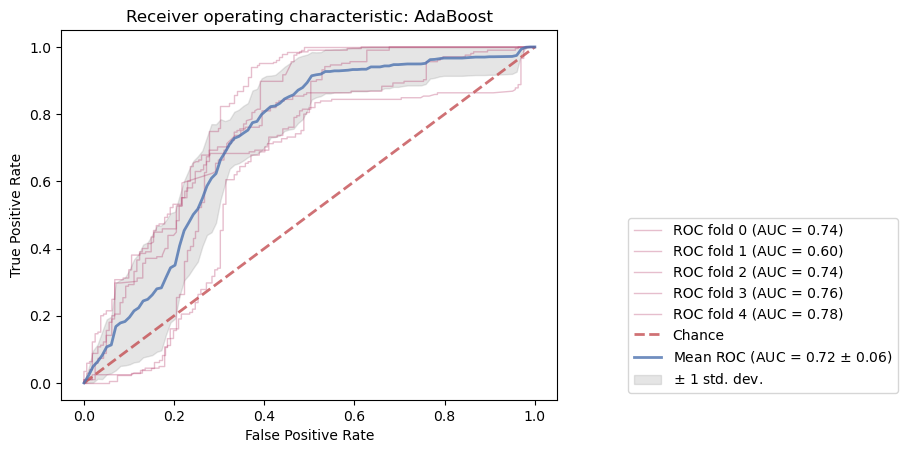

In [148]:
model_name = 'AdaBoost'
classifier = make_pipeline(preprocessing.StandardScaler(), AdaBoostClassifier(n_estimators=100, random_state=0))
ROC_cv(model_name,classifier)

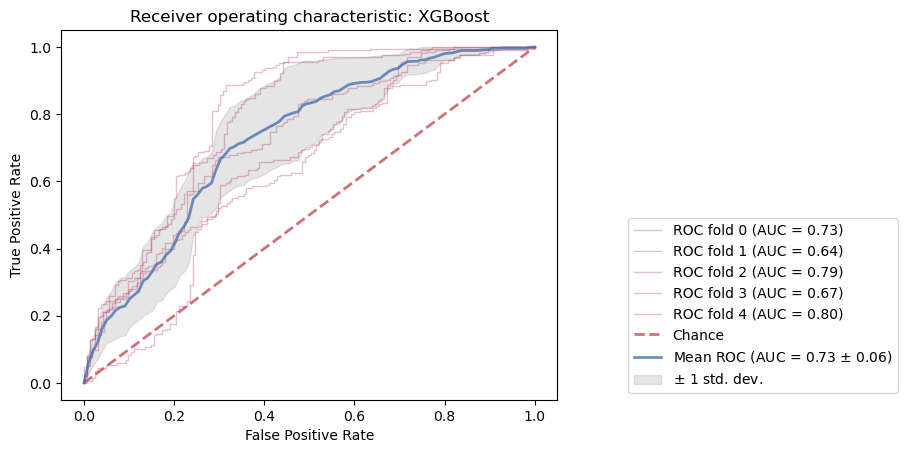

In [149]:
model_name = 'XGBoost'
classifier = make_pipeline(preprocessing.StandardScaler(), XGBClassifier())
ROC_cv(model_name,classifier)

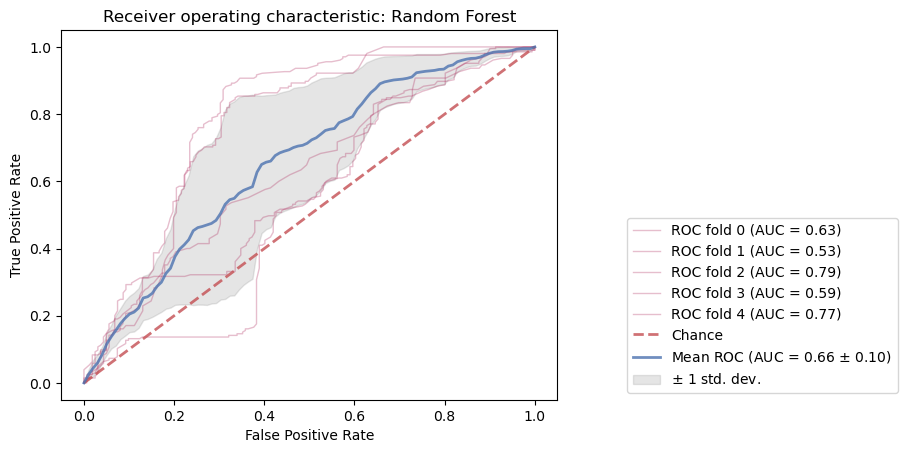

In [150]:
model_name = 'Random Forest'
classifier = RandomForestClassifier(n_estimators=200)
ROC_cv(model_name,classifier)

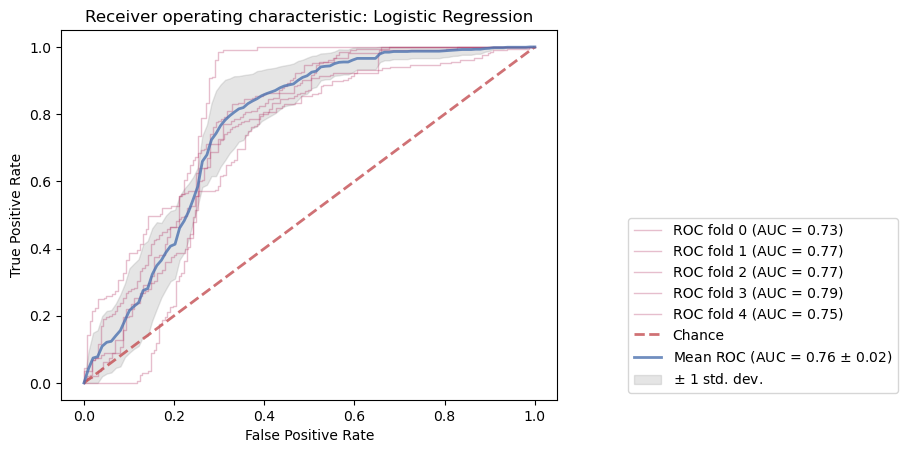

In [151]:
model_name = 'Logistic Regression'
classifier = make_pipeline(preprocessing.StandardScaler(), LogisticRegression(solver='newton-cg',C=100,penalty='l2'))
ROC_cv(model_name,classifier)

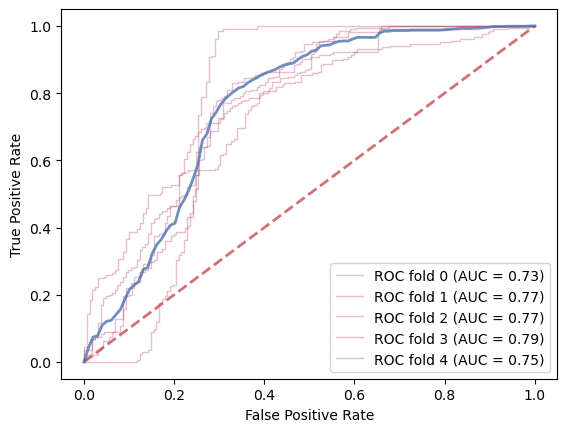

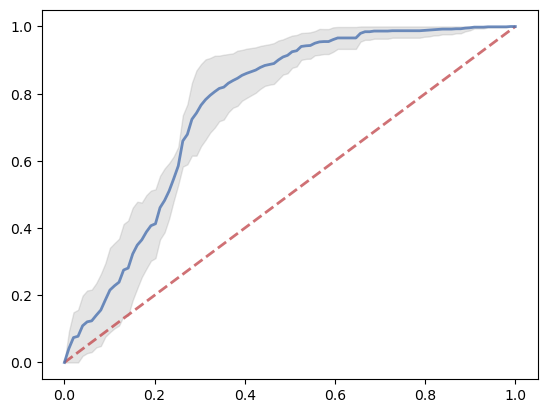

In [162]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

cv = StratifiedKFold(n_splits=5)

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X[train], y[train])
    viz = plot_roc_curve(classifier, X[test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)

fig, ax = plt.subplots()
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8);

### wandb VIZ

In [163]:
# import wandb
# wandb.init(project="visualize-sklearn")

In [164]:
# # Visualize single plot
# wandb.sklearn.plot_confusion_matrix(y_test, y_predict, labels)

### Compare different models

/Users/katiehuang/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


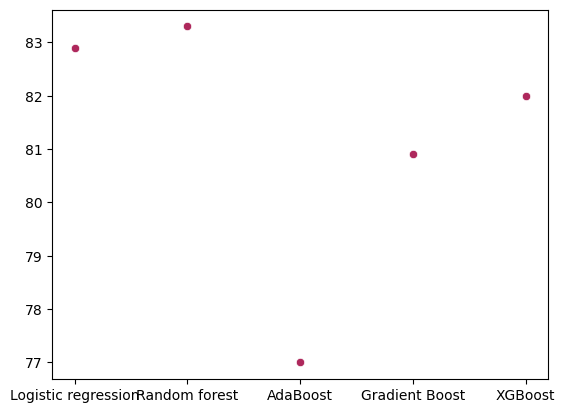

In [166]:
models = ['Logistic regression','Random forest','AdaBoost','Gradient Boost','XGBoost']
AUC_scores = [82.9,83.3,77,80.9,82]

sns.scatterplot(models,AUC_scores);